In [1]:
import sys
import torch
import time, os
import numpy as np

folder_path = '../models/'
if folder_path not in sys.path:
    sys.path.append(folder_path)

folder_path = '../data/'
if folder_path not in sys.path:
    sys.path.append(folder_path)

from pemp import PEMP
from data_generators import *


torch.set_float32_matmul_precision('high')

def get_free_gpu():
    gpu_util = []
    for i in range(torch.cuda.device_count()):
        torch.cuda.set_device(i)  # Switch GPU
#        gpu_util.append((i, torch.cuda.memory_stats()['reserved_bytes.all.current'] / (1024 ** 2)))
        gpu_util.append((i, torch.cuda.utilization()))
    gpu_util.sort(key=lambda x: x[1])
    return gpu_util[0][0]

if torch.cuda.is_available():
    available_gpu = get_free_gpu()
    if available_gpu == 0:
        device = torch.device("cuda:0")
    else:
        device = torch.device(f"cuda:{available_gpu}")
else:
    device = torch.device("cpu")

print("Device :", device)

Device : cuda:0


In [2]:
dx, dy, dg, dpe = 1, 1, 0, 4
num_demos, num_val = 3, 1
num_trajs = num_demos + num_val
t_steps = 200
n_max, m_max = 10, 10
num_peaks_max = dg

x = torch.linspace(0, 1, t_steps).view(-1, 1)

y, pp = one_peak(num_trajs)

# interp = True
# if interp:
#     val_ids = torch.from_numpy(np.random.choice(np.arange(1, num_trajs-1), num_val, replace=False))
#     train_ids = [i for i in range(num_trajs) if i not in val_ids]
# else:
#     train_ids = torch.arange(num_demos)
#     val_ids = torch.arange(num_demos, num_trajs)

# gamma_train = pp[train_ids].clone()
# gamma_val = pp[val_ids].clone()
train_ids = torch.tensor([0, 1, 3])
val_ids = torch.tensor([2])

test_cond_ind = int(pp[val_ids, 0].item() * 200)

y_train = y[train_ids].clone()
y_val = y[val_ids].clone()

x_train = x.unsqueeze(0).repeat(num_demos, 1, 1)
x_val = x.unsqueeze(0).repeat(num_val, 1, 1)

# Print shapes
print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
print(f"x_val shape: {x_val.shape}, y_val shape: {y_val.shape}")

x_train shape: torch.Size([3, 200, 1]), gamma_train shape: torch.Size([3, 1]), y_train shape: torch.Size([3, 200, 1])
x_val shape: torch.Size([1, 200, 1]), gamma_val shape: torch.Size([1, 1]), y_val shape: torch.Size([1, 200, 1])


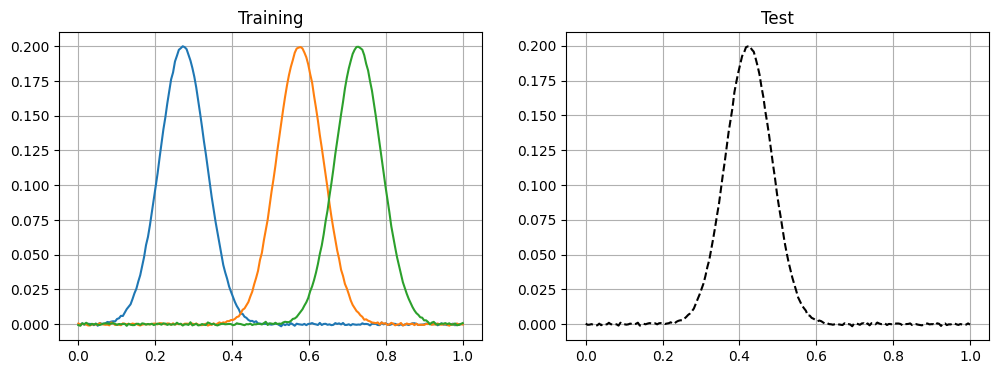

In [3]:
import matplotlib.pyplot as plt
# plot train trajectories on the left and validation trajectories on the right
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
for i in range(num_demos):
    axs[0].plot(x_train[i, :, 0], y_train[i, :, 0], label=f"Demo {i}")
for i in range(num_val):
    axs[1].plot(x_val[i, :, 0], y_val[i, :, 0], label=f"Val {i}", color='black', linestyle='dashed')
axs[0].set_title("Training")
axs[1].set_title("Test")
axs[0].grid(True)
axs[1].grid(True)
plt.show()

In [4]:
batch_size = 1

model = PEMP(input_dim=dpe, output_dim=dy, n_max=n_max, m_max=m_max, encoder_hidden_dims=[128, 128, 128], decoder_hidden_dims=[128, 128, 128], batch_size=batch_size, device=device)
optimizer = torch.optim.Adam(lr=3e-4, params=model.parameters())

pytorch_total_params = sum(p.numel() for p in model.parameters())
print(pytorch_total_params)


if torch.__version__ >= "2.0":
    model_ = torch.compile(model)
else:
    model_ = model

67586


In [5]:
import math

def generate_positional_encoding(length=t_steps, d_model=dpe, frequency_scaler=0.4):  # d_model: dimension of encoding space
    pos = torch.arange(length).unsqueeze(1).float()  # (length, 1)
    div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))  # (d_model/2,)
    div_term *= frequency_scaler  # Scale the frequency

    pe = torch.zeros(length, d_model)  # (length, d_model)
    pe[:, 0::2] = torch.sin(pos * div_term)
    pe[:, 1::2] = torch.cos(pos * div_term)
    return pe

pe = generate_positional_encoding() / dpe

In [6]:
dpe_aug = dpe + dg  # dg for gamma (peak_positions)

obs = torch.zeros((batch_size, n_max, dpe_aug+dy), dtype=torch.float32, device=device)
tar_x = torch.zeros((batch_size, m_max, dpe_aug), dtype=torch.float32, device=device)
tar_y = torch.zeros((batch_size, m_max, dy), dtype=torch.float32, device=device)
obs_mask = torch.zeros((batch_size, n_max), dtype=torch.bool, device=device)
tar_mask = torch.zeros((batch_size, m_max), dtype=torch.bool, device=device)

def prepare_masked_batch(t: list, traj_ids: list):
    obs.fill_(0)
    tar_x.fill_(0)
    tar_y.fill_(0)
    obs_mask.fill_(False)
    tar_mask.fill_(False)

    for i, traj_id in enumerate(traj_ids):
        traj = t[traj_id]

        # gamma = torch.zeros(dg)
        # for ppid, pp in enumerate(gamma_train[traj_id]):
        #     gamma[ppid] = pp  # gamma: peak_positions

        n = torch.randint(5, n_max, (1,)).item()
        m = torch.randint(1, m_max, (1,)).item()

        permuted_ids = torch.randperm(t_steps)
        n_ids = permuted_ids[:n]
        m_ids = permuted_ids[n:n+m]
        
        obs[i, :n, :dpe] = pe[n_ids] # PE(t)
        # obs[i, :n, dpe:dpe_aug] = gamma
        obs[i, :n, dpe_aug:] = traj[n_ids]  # SM(t)
        obs_mask[i, :n] = True
        
        tar_x[i, :m, :dpe] = pe[m_ids]
        # tar_x[i, :m, dpe:] = gamma
        tar_y[i, :m] = traj[m_ids]
        tar_mask[i, :m] = True

val_obs = torch.zeros((batch_size, n_max, dpe_aug+dy), dtype=torch.float32, device=device)
val_tar_x = torch.zeros((batch_size, t_steps, dpe_aug), dtype=torch.float32, device=device)
val_tar_y = torch.zeros((batch_size, t_steps, dy), dtype=torch.float32, device=device)
val_obs_mask = torch.zeros((batch_size, n_max), dtype=torch.bool, device=device)

def prepare_masked_val_batch(t: list, traj_ids: list, fixed_ind=None):
    val_obs.fill_(0)
    val_tar_x.fill_(0)
    val_tar_y.fill_(0)
    val_obs_mask.fill_(False)

    for i, traj_id in enumerate(traj_ids):
        traj = t[traj_id]
        
        # gamma = torch.zeros(dg)
        # for ppid, pp in enumerate(gamma_val[traj_id]):
        #     gamma[ppid] = pp  # gamma: peak_positions

        n = 1#torch.randint(5, n_max, (1,)).item()

        permuted_ids = torch.randperm(t_steps)
        n_ids = permuted_ids[:n]
        m_ids = torch.arange(t_steps)
        if fixed_ind != None:
            n_ids[-1] = fixed_ind
        
        val_obs[i, :n, :dpe] = pe[n_ids]
        # val_obs[i, :n, dpe:dpe_aug] = gamma
        val_obs[i, :n, dpe_aug:] = traj[n_ids]
        val_obs_mask[i, :n] = True
        
        val_tar_x[i, :, :dpe] = pe
        # val_tar_x[i, :, dpe:] = gamma
        val_tar_y[i] = traj[m_ids]

In [8]:
import time
import os

timestamp = int(time.time())
root_folder = f'../outputs/tests/simple/pemp/{str(timestamp)}/'

if not os.path.exists(root_folder):
    os.makedirs(root_folder)

if not os.path.exists(f'{root_folder}saved_models/'):
    os.makedirs(f'{root_folder}saved_models/')

img_folder = f'{root_folder}img/'
if not os.path.exists(img_folder):
    os.makedirs(img_folder)

torch.save(y_train, f'{root_folder}y.pt')

epochs = 2000000
epoch_iter = num_demos // batch_size
v_epoch_iter = num_val//batch_size
avg_loss = 0
val_per_epoch = 1000
min_val_loss = 1000000
mse_loss = torch.nn.MSELoss()

plot_validation = True


for epoch in range(epochs):
    epoch_loss = 0

    traj_ids = torch.randperm(num_demos)[:batch_size * epoch_iter].chunk(epoch_iter)

    for i in range(epoch_iter):
        prepare_masked_batch(y_train, traj_ids[i])

        optimizer.zero_grad()
        
        pred = model(obs, tar_x, obs_mask)
        loss = model.loss(pred, tar_y, tar_mask)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    if epoch % val_per_epoch == 0 and epoch > 0:
        with torch.no_grad():
            v_traj_ids = torch.randperm(num_val)[:batch_size*v_epoch_iter].chunk(v_epoch_iter)
            val_loss = 0

            for j in range(v_epoch_iter):
                prepare_masked_val_batch(y_val, v_traj_ids[j], test_cond_ind)
                pred = model.val(val_obs, val_tar_x, val_obs_mask)
                if plot_validation:
                    for k in range(batch_size):
                        plt.plot(val_tar_y[k, :, 0].cpu().numpy(), label=f"True {k}")
                        plt.plot(pred[k, :, 0].cpu().numpy(), label=f"Pred {k}")
                        
                        plt.legend()
                        plt.savefig(f'{img_folder}test_{epoch}_{j}_{k}.png')
                        plt.clf()
                val_loss += mse_loss(pred[:, :, :model.output_dim], val_tar_y).item()
                
            if val_loss < min_val_loss:
                min_val_loss = val_loss
                print(f'New best: {min_val_loss}')
                torch.save(model_.state_dict(), f'{root_folder}saved_models/pemp.pt')

    if epoch % 10000 == 0:
        with torch.no_grad():
            prepare_masked_val_batch(y_train, [0], 50)
            pred = model.val(val_obs, val_tar_x, val_obs_mask)
            if plot_validation:
                for k in range(batch_size):
                    plt.plot(val_tar_y[k, :, 0].cpu().numpy(), label=f"True {k}")
                    plt.plot(pred[k, :, 0].cpu().numpy(), label=f"Pred {k}")
                    
                    plt.legend()
                    plt.savefig(f'{img_folder}train_{epoch}_0_{k}.png')
                    plt.clf()

    avg_loss += epoch_loss

    if epoch % 100 == 0:
        print("Epoch: {}, Loss: {}".format(epoch, avg_loss / 100))
        avg_loss = 0

Epoch: 0, Loss: 0.01627710521221161
Epoch: 100, Loss: -3.527471917998046
Epoch: 200, Loss: -3.7922465179860594
Epoch: 300, Loss: -3.8663288173545154
Epoch: 400, Loss: -4.0859438963234425
Epoch: 500, Loss: -4.004876758269965
Epoch: 600, Loss: -3.9519904828071595
Epoch: 700, Loss: -3.8337201548554005
Epoch: 800, Loss: -4.103827692940831
Epoch: 900, Loss: -3.8679295140504837
New best: 0.004048981703817844
Epoch: 1000, Loss: -3.897921817302704
Epoch: 1100, Loss: -4.242699061632156
Epoch: 1200, Loss: -3.9424108327180147
Epoch: 1300, Loss: -3.9801529026031495
Epoch: 1400, Loss: -4.09637329146266
Epoch: 1500, Loss: -4.025099924057722
Epoch: 1600, Loss: -4.0184788696467875
Epoch: 1700, Loss: -4.007491028904915
Epoch: 1800, Loss: -4.089846425205469
Epoch: 1900, Loss: -3.9597949886322024
New best: 0.003369746031239629
Epoch: 2000, Loss: -3.9130577230080963
Epoch: 2100, Loss: -4.13614355109632
Epoch: 2200, Loss: -3.8489607893675566
Epoch: 2300, Loss: -3.9995387856662274
Epoch: 2400, Loss: -4.1741

KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>